In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
from xy_plots import x_vs_y

In [6]:
samples = Table.read('../fits/SF_fits/samples.fits')
sparcfire_samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')
mendel_masses = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
sparcfire = Table.read('../fits/sparcfire/pitch_angles.fits')
sfrs = Table.read('../fits/SF_fits/sfrs.fits')

In [4]:
# GZ2 m+w statistics
gz_data = Table.read('../fits/full_sample_debiased_w_low_z.fits')

def measure_weighted_average(data,columns):
    p_array = np.array([data[c] for c in columns]).T
    p_array[np.isfinite(p_array) == False] = 0
    p_mean = np.zeros(len(p_array))
    p_sum = np.sum(p_array,axis=1)
    for c in range(len(columns)):
        p_mean += (c+1)*p_array[:,c]
    p_mean = p_mean/p_sum
    p_mean[np.isfinite(p_mean) == False] = 0
    p_absolute = np.argmax(p_array,axis=1) + 1
    return p_mean, p_absolute

columns = ['t11_arms_number_a31_1_debiased_rh',
           't11_arms_number_a32_2_debiased_rh',
           't11_arms_number_a33_3_debiased_rh',
           't11_arms_number_a34_4_debiased_rh',
           't11_arms_number_a36_more_than_4_debiased_rh']

m_wtd_avg, m_absolute = measure_weighted_average(gz_data,columns)

columns = ['t10_arms_winding_a28_tight_debiased_rh',
           't10_arms_winding_a29_medium_debiased_rh',
           't10_arms_winding_a30_loose_debiased_rh']

w_wtd_avg, w_absolute = measure_weighted_average(gz_data,columns)

gz2_statistics = Table(np.array([m_absolute,m_wtd_avg,w_absolute,w_wtd_avg]).T,
                       names=('m','m_wtd_avg','w','w_wtd_avg'))

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


In [13]:
sparcfire_spirals = np.all([sparcfire_samples['in_spiral'],sparcfire_samples['unbarred'],
                            sparcfire_samples['in_mass_limit'],sparcfire_samples['axial_ok'],
                            #sparcfire['P'] > -999],axis=0)

print('{} spiral galaxies have OK SpArcFiRe analysis'.format(sparcfire_spirals.sum()))

ok_bulge = mendel_masses['bulge'] > 0
ok_disc = mendel_masses['disc'] > 0
ok_both = np.all([ok_bulge,ok_disc],axis=0)
btr = 10**(mendel_masses['bulge']-mendel_masses['bulge+disc'])
btr[ok_both == False] = -999
mendel_masses['btr'] = btr
mendel_masses.write('../fits/Simard+Mendel/mendel_masses.fits',overwrite=True)
mendel_spirals = np.all([sparcfire_spirals,ok_both],
                        axis=0)
print('---> {} have good B+D'.format(mendel_spirals.sum()))

mir_ok = sfrs['w4'] >= 2
fuv_ok = sfrs['F'] >= 2
sfr_spirals = np.all([sparcfire_spirals,mir_ok,fuv_ok],
                     axis=0)

print('+ {} have good SFRs'.format(sfr_spirals.sum()))

2614 spiral galaxies have OK SpArcFiRe analysis
---> 2614 have good B+D
+ 1101 have good SFRs


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [8]:
x = sparcfire_properties['P'][sparcfire_spirals]

plt.hist(sparcfire_properties['P'][sparcfire_spirals])
plt.axvline(np.percentile(x,16),color='k',lw=2)
plt.axvline(np.percentile(x,50),color='k',lw=2)
plt.axvline(np.percentile(x,84),color='k',lw=2)
plt.xlabel('$P$')
plt.ylabel('$N_\mathrm{gal}$')

NameError: name 'sparcfire_properties' is not defined

In [9]:
def bulge_disc_panels(y,mask,axarr=None,bins=8,equal_N=True,
                      ylabel='y',xlabel=True,figlabel=None,
                      **kwargs):
    if axarr is None:
        fig, axarr = plt.subplots(1,4,figsize=(20,5))
    bd_colnames = ['bulge','disc','bulge+disc','btr']
    bd_xlabels = ['$\log(M_\mathrm{bulge})$','$\log(M_\mathrm{disc})$',
                  '$\log(M_\mathrm{bulge}+M_\mathrm{disc})$','$M_B/M_T$']
    for a, ax in enumerate(axarr):
        bd_data = mendel_masses[bd_colnames[a]]
        _ = x_vs_y(bd_data[mask],y[mask]).continuous_vs_continuous_binned(ax,bins,equal_N,
                                                                          **kwargs)
        if xlabel is True:
            ax.set_xlabel(bd_xlabels[a])
    axarr[0].set_ylabel(ylabel)
    if figlabel is not None:
        axarr[-1].text(0.975,0.975,figlabel,
                       ha='right',va='top',transform=axarr[-1].transAxes)
    return axarr

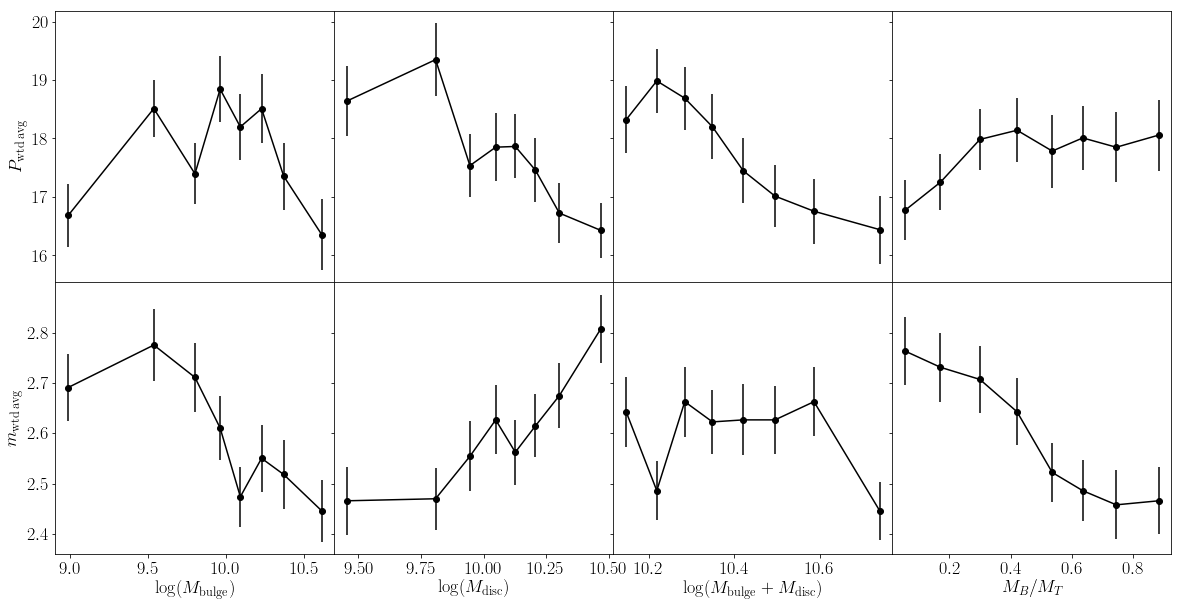

In [89]:
fig, axarr = plt.subplots(2,4,figsize=(20,10),
                          sharey='row',sharex='col')
fig.subplots_adjust(wspace=0,hspace=0)

y = sparcfire['P']
y2 = gz2_statistics['m']
mask = mendel_spirals
_ = bulge_disc_panels(y,mask,axarr[0],
                      ylabel='$P_\mathrm{wtd \, avg}$',xlabel=True,
                      color='k',marker='o')

_ = bulge_disc_panels(y2,mask,axarr[1],
                      ylabel='$m_\mathrm{wtd \, avg}$',xlabel=True,
                      color='k',marker='o')

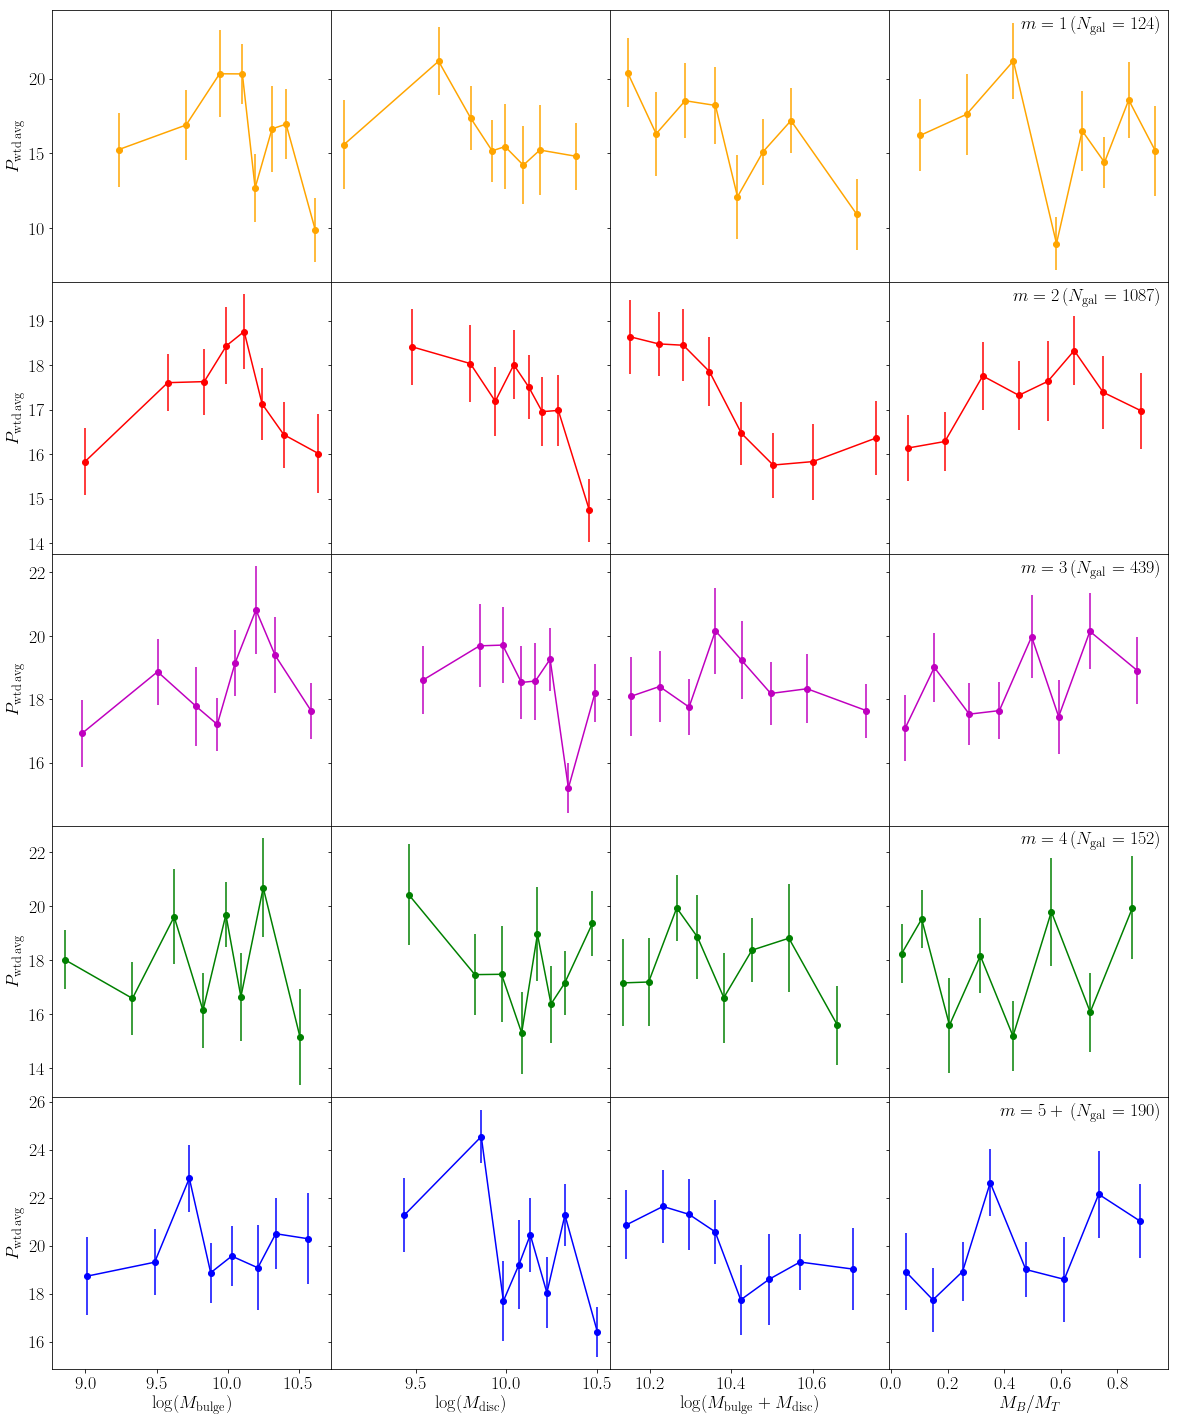

In [90]:
fig, axarr = plt.subplots(5,4,figsize=(20,25),
                          sharey='row',sharex='col')
fig.subplots_adjust(wspace=0,hspace=0)
colors = ['orange','r','m','g','b']
mlabels = ['1','2','3','4','5+']
y = sparcfire['P']
mask0 = mendel_spirals
for m in range(5):
    mask_m = gz2_statistics['m'] == m+1
    mask = np.all([mask0,mask_m],
                  axis=0)
    figlabel = '$m={} \, (N_\mathrm{{gal}}={})$'.format(mlabels[m],mask.sum())
    _ = bulge_disc_panels(y,mask,axarr[m],bins=8,
                          ylabel='$P_\mathrm{wtd \, avg}$',xlabel=True,
                          figlabel=figlabel,
                          color=colors[m],marker='o')

In [11]:
def sfr_panels(y,mask,axarr=None,bins=8,equal_N=True,
               ylabel='y',xlabel=True,figlabel=None,
               **kwargs):
    if axarr is None:
        fig, axarr = plt.subplots(1,3,figsize=(10,3.3))
    sfr_colnames = ['sfr_fuv','sfr_22','sfr_total']
    sfr_xlabels = ['$\log(SFR_\mathrm{FUV})$','$\log(SFR_\mathrm{22})$',
                  '$\log(SFR_\mathrm{FUV}+SFR_\mathrm{22})$']
    for a, ax in enumerate(axarr):
        sfr_data = sfrs[sfr_colnames[a]]
        _ = x_vs_y(sfr_data[mask],y[mask]).continuous_vs_continuous_binned(ax,bins,equal_N,
                                                                           **kwargs)
        if xlabel is True:
            ax.set_xlabel(sfr_xlabels[a])
    axarr[0].set_ylabel(ylabel)
    if figlabel is not None:
        axarr[-1].text(0.975,0.975,figlabel,
                       ha='right',va='top',transform=axarr[-1].transAxes)
    return axarr

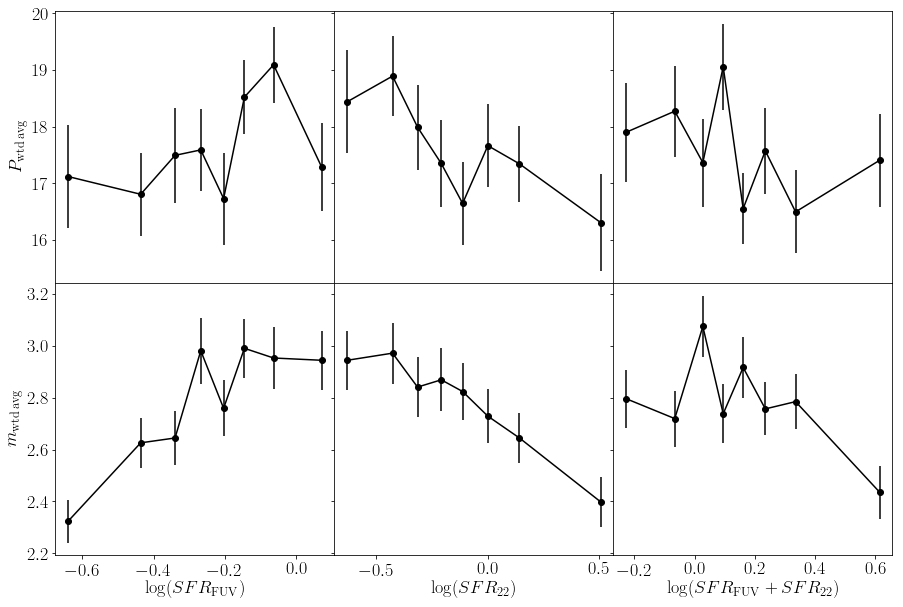

In [12]:
fig, axarr = plt.subplots(2,3,figsize=(15,10),
                          sharey='row',sharex='col')
fig.subplots_adjust(wspace=0,hspace=0)

y = sparcfire['P']
y2 = gz2_statistics['m']
mask = sfr_spirals
_ = sfr_panels(y,mask,axarr[0],
               ylabel='$P_\mathrm{wtd \, avg}$',xlabel=True,
               color='k',marker='o')

_ = sfr_panels(y2,mask,axarr[1],
               ylabel='$m_\mathrm{wtd \, avg}$',xlabel=True,
               color='k',marker='o')

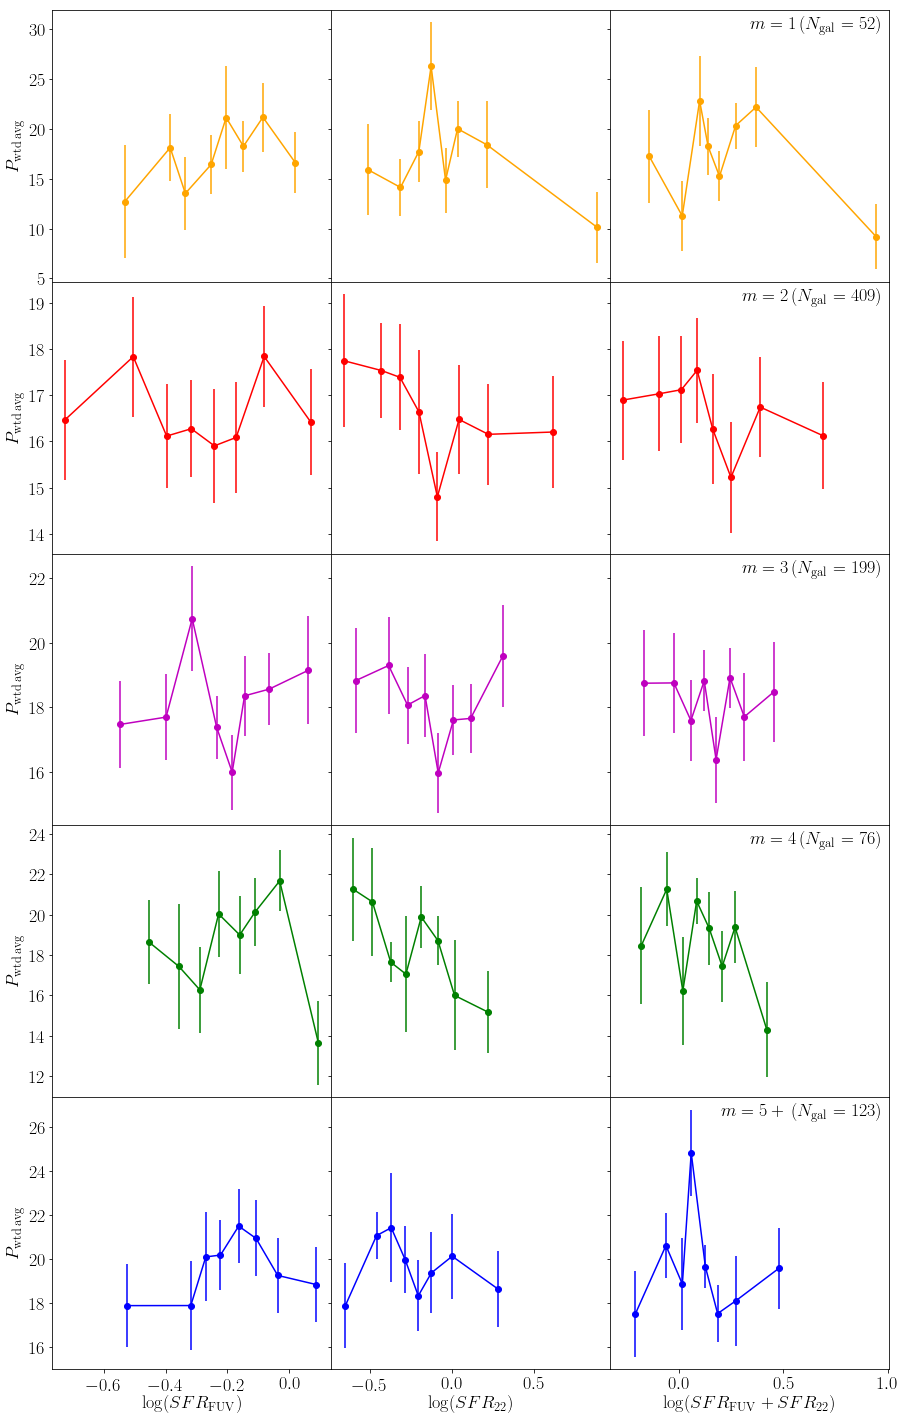

In [93]:
fig, axarr = plt.subplots(5,3,figsize=(15,25),
                          sharey='row',sharex='col')
fig.subplots_adjust(wspace=0,hspace=0)
colors = ['orange','r','m','g','b']
mlabels = ['1','2','3','4','5+']
y = sparcfire['P']
mask0 = sfr_spirals
for m in range(5):
    mask_m = gz2_statistics['m'] == m+1
    mask = np.all([mask0,mask_m],
                  axis=0)
    figlabel = '$m={} \, (N_\mathrm{{gal}}={})$'.format(mlabels[m],mask.sum())
    _ = sfr_panels(y,mask,axarr[m],bins=8,
                   ylabel='$P_\mathrm{wtd \, avg}$',xlabel=True,
                   figlabel=figlabel,
                   color=colors[m],marker='o')

#### What about galaxy environment and the presence of bars?

In [121]:
sparcfire_barred_spirals = np.all([samples['in_spiral'],samples['axial_ok'],
                                   mendel_masses['in_mass_limit'],
                                   sparcfire['P'] > -999],axis=0)

sfr_barred_spirals = np.all([sparcfire_barred_spirals,mir_ok,fuv_ok],
                             axis=0)

print('---> {} have good SFRs'.format(sfr_barred_spirals.sum()))

---> 1219 have good SFRs


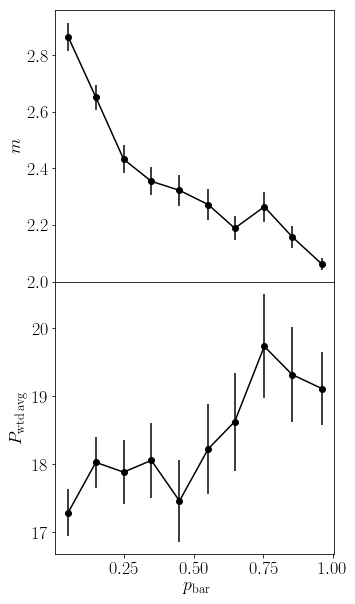

In [106]:
fig, axarr = plt.subplots(2,1,figsize=(5,10),
                          sharex=True)

fig.subplots_adjust(wspace=0,hspace=0)

x = samples['p_bar'][sparcfire_barred_spirals]
y0 = gz2_statistics['m'][sparcfire_barred_spirals]
y1 = sparcfire['P'][sparcfire_barred_spirals]
ax = axarr[0]
x_vs_y(x,y0).continuous_vs_continuous_binned(ax,color='k',marker='o')
ax.set_ylabel('$m$')

ax = axarr[1]
x_vs_y(x,y1).continuous_vs_continuous_binned(ax,color='k',marker='o')
ax.set_ylabel('$P_\mathrm{wtd \, avg}$')

axarr[-1].set_xlabel('$p_\mathrm{bar}$')

In [108]:
#gz_data = Table.read('../fits/full_sample_debiased_w_low_z.fits')

gz2_statistics['logSigma'] = gz_data['IVAN_DENSITY']

In [142]:
mir_fraction = (10**(sfrs['sfr_22']-sfrs['sfr_total']))
mir_fraction[np.isfinite(mir_fraction) ==  False] = -999
sfrs['mir_fraction'] = mir_fraction
sfrs.write('../fits/SF_fits/sfrs.fits',overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':


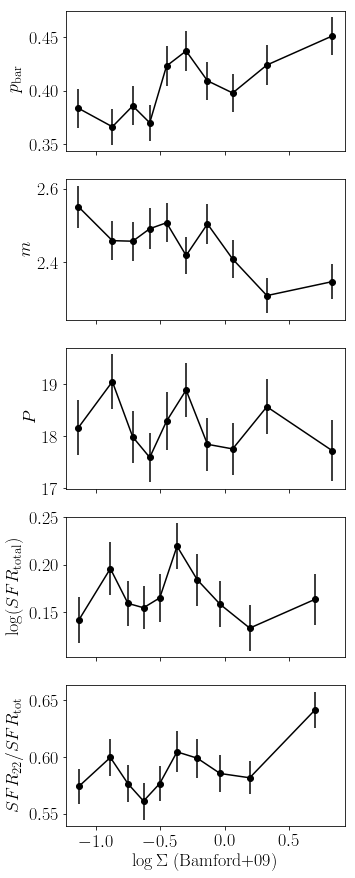

In [153]:
fig, axarr = plt.subplots(5,1,figsize=(5,15),
                          sharex=True)
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0.2,wspace=0)
#fig.delaxes(axarr[-1])

x = gz2_statistics['logSigma'][sparcfire_barred_spirals]
ys = [samples['p_bar'][sparcfire_barred_spirals],
      gz2_statistics['m'][sparcfire_barred_spirals],
      sparcfire['P'][sparcfire_barred_spirals]]

ylabels = ['$p_\mathrm{bar}$','$m$','$P$',
           '$\log(SFR_\mathrm{total})$','$SFR_\mathrm{22}/SFR_\mathrm{tot}$']

for i, y in enumerate(ys):
    ax = axarr[i]
    x_vs_y(x,y).continuous_vs_continuous_binned(ax,color='k',marker='o',
                                                equal_N=True)
    ax.set_ylabel(ylabels[i])

x2 = gz2_statistics['logSigma'][sfr_barred_spirals]
y2s = [sfrs['sfr_total'][sfr_barred_spirals],
       sfrs['mir_fraction'][sfr_barred_spirals]]

for i2, y2 in enumerate(y2s):
    ax = axarr[i2+3]
    x_vs_y(x2,y2).continuous_vs_continuous_binned(ax,color='k',marker='o',
                                                  equal_N=True)
    ax.set_ylabel(ylabels[i2+3])
    
axarr[-1].set_xlabel('$\log \Sigma$ (Bamford+09)')

In [338]:
from sklearn.decomposition import PCA

n = 1 # sets random noise

x = np.random.randn(200)
y = x + n*np.random.randn(200)
z = np.random.randn(200)

xyz = np.array([x,y,z]).T
pca = PCA().fit(xyz)
components = pca.components_
ratios = pca.explained_variance_ratio_
print(components,ratios)

[[ 0.56840485  0.8210453   0.05292017]
 [ 0.01264272  0.0555973  -0.99837323]
 [-0.82265187  0.56814924  0.02122153]] [ 0.62617755  0.27950422  0.09431823]


In [339]:
_ = pca.score(xyz)
print(_)

-4.11700329131
